In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, concatenate
from tensorflow.keras.models import Model

GPU settings.

In [8]:
import os
os.environ['TF_METAL_ENABLE_MPS'] = '1'

In [9]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2023-01-10 17:41:00.066475: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 17:41:00.066517: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Now, in order to use the GPU, I need to run my code inside:


`with tf.device('/device:GPU:0'):`


Exactly as shown in the example.

Function to plot history recordings data.

In [10]:
import matplotlib.pyplot as plt

def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Generator.

In [11]:
def polar_generator(batchsize,grid=(10,10),noise=.002,flat=False):
  while True:
    x = np.random.rand(batchsize)
    y = np.random.rand(batchsize)
    out = np.zeros((batchsize,grid[0],grid[1]))
    xc = (x*grid[0]).astype(int)
    yc = (y*grid[1]).astype(int)
    for b in range(batchsize):
      out[b,xc[b],yc[b]] = 1
    #compute rho and theta and add some noise
    rho = np.sqrt(x**2+y**2) + np.random.normal(scale=noise)
    theta = np.arctan(y/np.maximum(x,.00001)) + np.random.normal(scale=noise)
    if flat:
      out = np.reshape(out,(batchsize,grid[0]*grid[1]))
    yield ((theta,rho),out)

Train and test arrays from generator.

In [32]:
import itertools
import numpy as np
from sklearn.model_selection import train_test_split

train_gen = itertools.islice(polar_generator(batchsize=1, grid=(10,10)), 10000)
#test_gen = itertools.islice(polar_generator(batchsize=1, grid=(10,10)), 50000) #should be validation set, and have the same elements of train_set
#print(next(gen))
print(type(train_gen))
"""
Before the error, the batchsize was 1
"""

<class 'itertools.islice'>


'\nBefore the error, the batchsize was 1\n'

Shape check.

In [33]:
train = list(train_gen)
#test = list(test_gen)

In [14]:
train[0]

((array([0.77286395]), array([1.26021606])),
 array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]]))

In [15]:
stop = False
for input_output in train:
    polar_input = input_output[0]
    grid_output = input_output[1]
    print("Should be the input:",polar_input)
    print("Should be the output:",grid_output)
    if stop:
        break
    else:
        for array in grid_output:
            for i,row in enumerate(array):
                print("This is the row ",i," :",row)
                stop=True

"""
    if stop:
        break
    else:
        for tup in input_output:
            print("This is the tuple:" ,tup)
            stop=True
"""

Should be the input: (array([0.77286395]), array([1.26021606]))
Should be the output: [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]]
This is the row  0  : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
This is the row  1  : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
This is the row  2  : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
This is the row  3  : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
This is the row  4  : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
This is the row  5  : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
This is the row  6  : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
This is the row  7  : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
This is the row  8  : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
This is the row  9  : [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Should be the input: (array([0.8

'\n    if stop:\n        break\n    else:\n        for tup in input_output:\n            print("This is the tuple:" ,tup)\n            stop=True\n'

Array conversion.

In [34]:
X_train = np.array([x for x, y in train])
y_train = np.array([array for x, y in train for array in y]) # for label in array])
"""
X_test = np.array([x for x, y in test])
y_test = np.array([array for x, y in test for array in y]) # for label in array])
"""

'\nX_test = np.array([x for x, y in test])\ny_test = np.array([array for x, y in test for array in y]) # for label in array])\n'

Array shape check.

In [35]:
print(X_train.shape)
print(y_train.shape)
"""
print(X_test.shape)
print(y_test.shape)
"""

(10000, 2, 1)
(10000, 10, 10)


'\nprint(X_test.shape)\nprint(y_test.shape)\n'

### Models

#### Model 1

In [24]:
# Working model_1 
# Accuracy on validation = 24% 
# Param = 3410
# Batch size = 64
# Generator Batchsize = 1
###################
# Working model_1 
# Accuracy on validation = 31% 
# Param = 3410
# Batch size = 32
# Generator Batchsize = 10

input_layer = Input(shape=(2,))
x = Dense(20, activation='relu')(input_layer)
x = Dense(30, activation='relu')(x)
x = Dense(20, activation='relu')(x)
output_layer = Dense(100,activation='relu')(x)

model = Model(input_layer,output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_8 (Dense)             (None, 20)                60        
                                                                 
 dense_9 (Dense)             (None, 30)                630       
                                                                 
 dense_10 (Dense)            (None, 20)                620       
                                                                 
 dense_11 (Dense)            (None, 100)               2100      
                                                                 
Total params: 3,410
Trainable params: 3,410
Non-trainable params: 0
_________________________________________________________________


#### Model 2

In [79]:
#  model_2 
# Accuracy on validation = ?? 
# Param = 2405
# Batch size = 64

input_layer = Input(shape=(10,2)) # If we go back to batchsize of 1 of the generator, we need input shape=(2,)
x = Dense(10, activation='relu')(input_layer)
x = Dense(30, activation='relu')(x)
x = Dense(20, activation='relu')(x)
x = Dense(10, activation='relu')(x)
output_layer = Dense(100,activation='softmax')(x)

mymodel = Model(input_layer,output_layer)

model = Model(input_layer,output_layer)
model.compile(optimizer="SGD", loss='mse', metrics=['accuracy'])
model.summary()

#### Model 3

In [116]:
# Model 3 - Working
# Epocs = 10
# Accuracy on validation = 0.7183
# Param = 2290
# Batch size = 32
# Generator Batchsize = 1
########################
#WITHOUT Flatten layer
# accuracy = 47%
# batch size = 128
# generator batchsize = 10
########################



from keras.layers import Input, Dense, Dropout, Flatten

input_layer = Input(shape=(10,2))
#x = Flatten()(input_layer)
x = Dense(10, activation='relu')(input_layer)
x = Dense(30, activation='relu')(x)
x = Dense(20, activation='relu')(x)
x = Dense(10, activation='relu')(x)
output_layer = Dense(100, activation='sigmoid')(x)

model = Model(input_layer, output_layer)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 10, 2)]           0         
                                                                 
 dense_96 (Dense)            (None, 10, 10)            30        
                                                                 
 dense_97 (Dense)            (None, 10, 30)            330       
                                                                 
 dense_98 (Dense)            (None, 10, 20)            620       
                                                                 
 dense_99 (Dense)            (None, 10, 10)            210       
                                                                 
 dense_100 (Dense)           (None, 10, 100)           1100      
                                                                 
Total params: 2,290
Trainable params: 2,290
Non-trainable 

#### Model 4

In [122]:
# Model 4 - Working
# Epocs = 10
# Accuracy on validation = 20%
# Param = 3520
# Batch size = 64
# Generator Batchsize = 10
########################
# This one overfits -> may be improved

from keras.layers import Input, Dense, Dropout, Flatten

input_layer = Input(shape=(10,2))
#x = Flatten()(input_layer)
x = Dense(10, activation='relu')(input_layer)
x = Dense(50, activation='relu')(x)
x = Dense(30, activation='relu')(x)
x = Dense(10, activation='relu')(x)
output_layer = Dense(100, activation='sigmoid')(x)

model = Model(input_layer, output_layer)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 10, 2)]           0         
                                                                 
 dense_106 (Dense)           (None, 10, 10)            30        
                                                                 
 dense_107 (Dense)           (None, 10, 50)            550       
                                                                 
 dense_108 (Dense)           (None, 10, 30)            1530      
                                                                 
 dense_109 (Dense)           (None, 10, 10)            310       
                                                                 
 dense_110 (Dense)           (None, 10, 100)           1100      
                                                                 
Total params: 3,520
Trainable params: 3,520
Non-trainable 

#### Model 5

In [141]:
# Model 5 - Working
# Epocs = 10
# Accuracy on validation = 89%
# Param = 2290
# Batch size = 64
# Generator Batchsize = 10
########################

from keras.layers import Input, Dense, Dropout, Flatten

input_layer = Input(shape=(10,2))
#x = Flatten()(input_layer)
x = Dense(10, activation='tanh')(input_layer)
x = Dense(30, activation='tanh')(x)
x = Dense(20, activation='tanh')(x) 
x = Dense(10, activation='relu')(x)
output_layer = Dense(100, activation='softmax')(x)

model = Model(input_layer, output_layer)
model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
model.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 10, 2)]           0         
                                                                 
 dense_121 (Dense)           (None, 10, 10)            30        
                                                                 
 dense_122 (Dense)           (None, 10, 30)            330       
                                                                 
 dense_123 (Dense)           (None, 10, 20)            620       
                                                                 
 dense_124 (Dense)           (None, 10, 10)            210       
                                                                 
 dense_125 (Dense)           (None, 10, 100)           1100      
                                                                 
Total params: 2,290
Trainable params: 2,290
Non-trainable 

In [79]:
print(history.history["val_accuracy"])

[0.026760002598166466, 0.13736000657081604, 0.3551400303840637, 0.47482001781463623, 0.5557000637054443, 0.5978000164031982, 0.7075400352478027, 0.736240029335022, 0.7611000537872314, 0.7588000297546387, 0.7754400372505188, 0.7990400791168213, 0.8028400540351868, 0.8154400587081909, 0.8356600403785706, 0.8194600343704224, 0.8296000361442566, 0.8338400721549988, 0.8455800414085388, 0.8562200665473938, 0.857900083065033, 0.8621000647544861, 0.8596400618553162, 0.8754200339317322, 0.8583800792694092, 0.8646600842475891, 0.8641600608825684, 0.8833000659942627, 0.8725600838661194, 0.8816800713539124, 0.8870600461959839, 0.8784400820732117, 0.8838200569152832, 0.8877600431442261, 0.8896000385284424, 0.8857000470161438, 0.89354008436203, 0.890440046787262, 0.890440046787262, 0.9013000726699829, 0.897580087184906, 0.8988000750541687, 0.8887800574302673, 0.9017800688743591, 0.9046000838279724, 0.9036400318145752, 0.9015800356864929, 0.8934400677680969]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


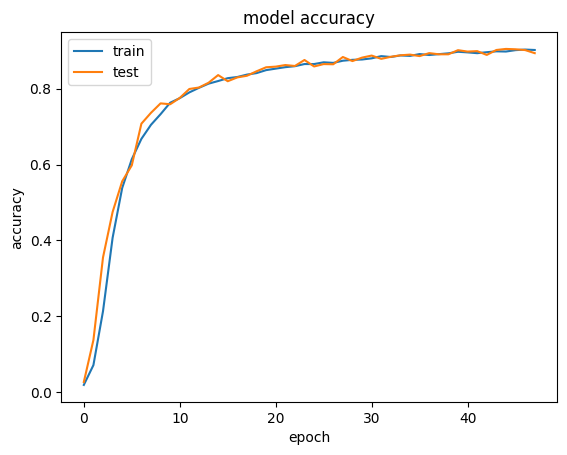

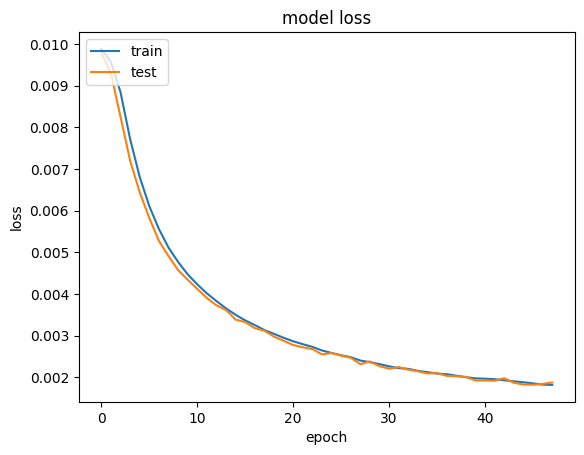

In [78]:
plot_history(history)

#### Model 6

In [154]:
# Model 6 - Working
# Epocs = 10
# Accuracy on validation = 89%
# Param = 2290
# Batch size = 64
# Generator Batchsize = 10
########################

from keras.layers import Input, Dense, Dropout, Flatten

input_layer = Input(shape=(2,))
print(input_layer.shape)
#x = Flatten()()
x = Dense(10, activation='tanh')(input_layer)
x = Dense(30, activation='tanh')(x)
#x = Dense(20, activation='tanh')(x) 
x = Dense(10, activation='relu')(x)
#x = Reshape((-1, input_layer.shape[2]))(x)
output_layer = Dense(100, activation='softmax')(x)

print(model.output_shape)

model = Model(input_layer, output_layer)
model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
model.summary()

(None, 2)
(None, 1, 1, 2)
Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_64 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_1126 (Dense)          (None, 10)                30        
                                                                 
 dense_1127 (Dense)          (None, 30)                330       
                                                                 
 dense_1128 (Dense)          (None, 10)                310       
                                                                 
 dense_1129 (Dense)          (None, 100)               1100      
                                                                 
Total params: 1,770
Trainable params: 1,770
Non-trainable params: 0
_________________________________________________________________


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


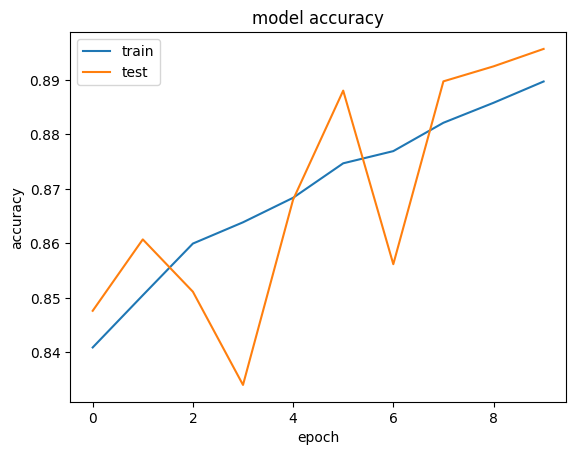

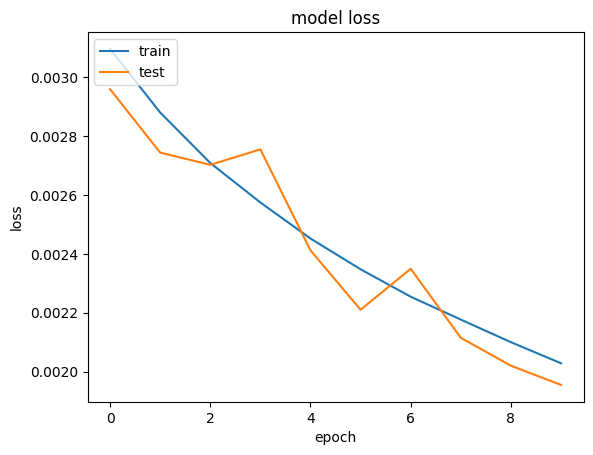

In [196]:
plot_history(history)

#### Model 7 - Test reshape and concatenate

In [36]:
from keras.layers import Input, concatenate, Dense, Reshape
from keras.models import Model

# Creating the input layer with shape (2,)
input_layer = Input(shape=(2,))

# Using dense layer to process the input
x = Dense(8, activation='relu')(input_layer)

#Using Dense layer for the output
outputs = [Dense(1, activation='sigmoid')(x) for _ in range(10*10)]

# Reshaping the output to make a 10x10 grid
reshape_layer = Reshape((10,10))
merged = reshape_layer(concatenate(outputs))

# Creating the model
model = Model(inputs=input_layer, outputs=merged)

model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
#model.optimizer(lr=0.001)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense_718 (Dense)              (None, 8)            24          ['input_9[0][0]']                
                                                                                                  
 dense_719 (Dense)              (None, 1)            9           ['dense_718[0][0]']              
                                                                                                  
 dense_720 (Dense)              (None, 1)            9           ['dense_718[0][0]']              
                                                                                            

In [18]:
print(X_train.shape)
print(y_train.shape)

(20000, 2, 1)
(20000, 10, 10)


In [ ]:
print(history.history["val_accuracy"])

In [ ]:
plot_history(history)

#### Model 8 - Test Conv2D 

In [152]:
# Not working
from keras.layers import Input, Conv2D, Activation, Reshape
from keras.models import Model

# Creating the input layer with shape (2,)
input_layer = Input(shape=(2,))

# reshaping the input layer to (batch_size, 1, 1, 2)
x = Reshape((1,1,2))(input_layer)

# Using a 2D convolutional layer with 1 filter of size (1,1)
x = Conv2D(filters=1, kernel_size=(1,1), data_format="channels_first")(x)

# Activation function
x = Activation("sigmoid")(x)

# Creating the model
model = Model(inputs=input_layer, outputs=x)

model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_63 (InputLayer)       [(None, 2)]               0         
                                                                 
 reshape_76 (Reshape)        (None, 1, 1, 2)           0         
                                                                 
 conv2d_642 (Conv2D)         (None, 1, 1, 2)           2         
                                                                 
 activation_11 (Activation)  (None, 1, 1, 2)           0         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


### Training the model

In [19]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

This training is without addition of reguarizations to the model.

In [ ]:
with tf.device('/device:GPU:0'):
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.5, shuffle=True) #validation_data=(X_test, y_test), shuffle=)

This other training is with regularization (l2).

In [37]:
from keras import callbacks
with tf.device('/device:GPU:0'):
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                            mode ="min", patience = 1, 
                                            restore_best_weights = True)
    
    history = model.fit(X_train, y_train, batch_size = 32, 
                        epochs = 6, validation_split=0.3,
                        shuffle=True, 
                        callbacks =[earlystopping])

Epoch 1/6
219/219 [==============================] - 25s 112ms/step - loss: 0.0841 - accuracy: 0.0347 - val_loss: 0.0277 - val_accuracy: 0.1028
Epoch 2/6
219/219 [==============================] - 24s 110ms/step - loss: 0.0189 - accuracy: 0.3335 - val_loss: 0.0142 - val_accuracy: 0.5441
Epoch 3/6
219/219 [==============================] - 24s 109ms/step - loss: 0.0128 - accuracy: 0.5711 - val_loss: 0.0118 - val_accuracy: 0.7333
Epoch 4/6
219/219 [==============================] - 24s 111ms/step - loss: 0.0113 - accuracy: 0.7618 - val_loss: 0.0109 - val_accuracy: 0.8203
Epoch 5/6
219/219 [==============================] - 24s 109ms/step - loss: 0.0107 - accuracy: 0.8039 - val_loss: 0.0105 - val_accuracy: 0.8203
Epoch 6/6
219/219 [==============================] - 24s 112ms/step - loss: 0.0104 - accuracy: 0.8215 - val_loss: 0.0103 - val_accuracy: 0.8203


In [38]:
def accuracy(model, X_test, y_test):
    # Predicts labels
    y_pred = model.predict(X_test)
    # Finds the coordinate of the value 1 within the predicted label's vector
    y_pred = np.argmax(y_pred, axis=1)
    # Finds the coordinate of the value 1 within the real label's vector
    y_test = np.argmax(y_test, axis=1)
    return np.sum(y_pred == y_test) / len(y_test)

In [39]:
real_test_gen = itertools.islice(polar_generator(batchsize=1, grid=(10,10)), 20000)

In [23]:
real_test = list(real_test_gen)
X_real_test = np.array([x for x, y in train])
y_real_test = np.array([array for x, y in train for array in y]) # for label in array])

In [ ]:
print(accuracy(model, X_real_test, y_real_test))

9.1018


In [47]:
print(np.argmax(y_pred[0]))

20


In [ ]:
print(np.argmax(y_pred[0]))
print(y_real_test[0])

----------------

---------------

In [123]:
# Functions to see better in order to produce the various sets
X_real_test, y_real_test = zip(*real_test_gen)
X_real_test = np.array(X_real_test)
y_real_test = np.array(y_real_test)

In [118]:
print(accuracy(model, X_test, y_test))

0.55868


In [116]:
for i,el in enumerate(y_pred):
    print(el == y_test_coordinates[i])
    print(el, y_test_coordinates[i])

True
50 50
True
26 26
False
46 45
True
3 3
True
26 26
False
38 48
False
29 39
True
4 4
False
14 15
False
46 45
False
38 39
False
79 78
True
91 91
True
44 44
True
99 99
True
87 87
False
1 0
True
31 31
False
23 33
False
87 86
True
71 71
False
50 40
False
26 25
True
54 54
True
37 37
False
75 76
False
96 97
True
67 67
True
8 8
True
96 96
True
9 9
True
8 8
True
71 71
False
38 29
True
22 22
False
7 6
True
18 18
True
75 75
True
50 50
True
90 90
True
32 32
True
58 58
True
84 84
True
15 15
False
8 18
False
9 19
True
43 43
True
42 42
True
38 38
True
74 74
False
99 98
True
22 22
False
29 39
True
10 10
True
96 96
True
1 1
False
96 86
False
79 68
False
26 25
False
87 86
True
20 20
True
84 84
True
20 20
True
43 43
False
79 78
False
67 76
False
64 75
True
2 2
False
18 17
True
19 19
False
75 85
True
96 96
False
56 57
False
44 45
False
93 92
True
9 9
True
47 47
True
52 52
False
38 49
True
16 16
True
14 14
True
22 22
True
26 26
True
21 21
True
34 34
True
11 11
False
96 85
False
79 77
True
71 71
False
26

In [112]:
y_test_coordinates = []
for el in y_test:
    for i,value in enumerate(el):
        if value == 1.:
            y_test_coordinates.append(i)